In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [19]:
# 가격 데이터 불러오기
price = pd.read_csv("../../data/features/final_oneHot/대게_price_features_oneHot.csv")
price = price.drop(["item"], axis=1)
price['date'] = pd.to_datetime(price['date'])
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24057 entries, 0 to 24056
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              24057 non-null  datetime64[ns]
 1   m_가락시장            24057 non-null  int64         
 2   m_노량진시장           24057 non-null  int64         
 3   m_강서농수산물시장        24057 non-null  int64         
 4   m_구리농수산물시장        24057 non-null  int64         
 5   m_마포농수산물시장        24057 non-null  int64         
 6   m_부산민락어민활어직판장     24057 non-null  int64         
 7   m_소래포구종합어시장       24057 non-null  int64         
 8   m_수원농수산물시장        24057 non-null  int64         
 9   m_안양평촌농수산물시장      24057 non-null  int64         
 10  m_인천종합연안부두어시장     24057 non-null  int64         
 11  avgPrice          24057 non-null  float64       
 12  avgPrice_lag_1    24049 non-null  float64       
 13  대게_20대_1          22301 non-null  float64       
 14  대게_20대_273        2079

In [28]:
# 독립변수(X)와 종속변수(y) 분리
X = price.drop(columns=[
    'date','m_가락시장','m_노량진시장','m_강서농수산물시장', 'm_구리농수산물시장', 'm_마포농수산물시장', 
    'm_부산민락어민활어직판장', 'm_소래포구종합어시장', 'm_수원농수산물시장', 'm_안양평촌농수산물시장',
    'm_인천종합연안부두어시장'])  # 가격 컬럼을 타겟으로 설정
y = price['m_가락시장']

# 데이터 정규화 (MinMaxScaler 적용)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 데이터 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [64]:
#결측치 평균값으로 채움
X.fillna(X.mean(), inplace=True)

#이전 값으로 채우기(시계열데이터 용)
# X.fillna(method='ffill', inplace=True)
print(X.isnull().sum())

avgPrice            0
avgPrice_lag_1      0
대게_20대_1            0
대게_20대_273          0
대게_30대_1            0
대게_30대_370          0
대게_40대_1            0
대게_40대_5            0
대게_50대_1            0
대게_50대_5            0
대게_60대이상_1          0
대게_60대이상_5          0
대게_Gold_177         0
대게_KOSPI_148        0
대게_Silver_177       0
대게_USD/KRW_90       0
대게_WTI_91           0
대게_기온_22105_150     0
대게_수온_22188_140     0
대게_습도_22188_355     0
대게_파주기_22105_174    0
dtype: int64


In [71]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 스케일링 확인
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [73]:
# 타겟 변수와 피처 분리
X = X_scaled  # 스케일링된 데이터를 사용
y = y  # 기존 y 그대로 사용 (결측치 없음 확인 완료)

# 80% 훈련, 20% 테스트로 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("훈련 데이터 크기:", X_train.shape, y_train.shape)
print("테스트 데이터 크기:", X_test.shape, y_test.shape)

테스트 데이터 크기: (4812, 21) (4812,)


In [74]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print("X_train_tensor 크기:", X_train_tensor.shape)
print("y_train_tensor 크기:", y_train_tensor.shape)
print("X_test_tensor 크기:", X_test_tensor.shape)
print("y_test_tensor 크기:", y_test_tensor.shape)

X_train_tensor 크기: torch.Size([19245, 21])
y_train_tensor 크기: torch.Size([19245, 1])
X_test_tensor 크기: torch.Size([4812, 21])
y_test_tensor 크기: torch.Size([4812, 1])


In [75]:
# 훈련 및 테스트 데이터셋 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader 설정 (배치 크기 설정)
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 데이터 로더 크기 확인
print(f"훈련 배치 개수: {len(train_loader)}")
print(f"테스트 배치 개수: {len(test_loader)}")

훈련 배치 개수: 602
테스트 배치 개수: 151


In [90]:
class ImprovedPricePredictionModel(nn.Module):
    def __init__(self, input_size):
        super(ImprovedPricePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

model = ImprovedPricePredictionModel(input_size)

# 새로운 모델 초기화
input_size = X_train_tensor.shape[1]  # 특성 수 확인
model = ImprovedPricePredictionModel(input_size)

# 옵티마이저 설정 (학습률 조정)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 200  # 에폭 증가

In [91]:
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [92]:
# 손실 함수 (회귀 문제이므로 MSELoss 사용)
criterion = nn.HuberLoss(delta=1.0)

# 옵티마이저 (Adam 옵티마이저 사용, 학습률 설정)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("손실 함수 및 옵티마이저 설정 완료")

손실 함수 및 옵티마이저 설정 완료


In [83]:
# 학습 설정
num_epochs = 100  # 에폭 수 증가
for epoch in range(num_epochs):
    model.train()  # 학습 모드
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # 기울기 초기화
        y_pred = model(X_batch)  # 모델 예측
        loss = criterion(y_pred, y_batch)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("모델 학습 완료!")

Epoch [10/100], Loss: 0.1059
Epoch [20/100], Loss: 0.0932
Epoch [30/100], Loss: 0.0829
Epoch [40/100], Loss: 0.0765
Epoch [50/100], Loss: 0.0715
Epoch [60/100], Loss: 0.0688
Epoch [70/100], Loss: 0.0667
Epoch [80/100], Loss: 0.0629
Epoch [90/100], Loss: 0.0628
Epoch [100/100], Loss: 0.0610
모델 학습 완료!


In [93]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

             Feature  Importance
1     avgPrice_lag_1    0.208996
0           avgPrice    0.206779
12       대게_Gold_177    0.064109
16         대게_WTI_91    0.056768
13      대게_KOSPI_148    0.056328
15     대게_USD/KRW_90    0.054646
14     대게_Silver_177    0.051212
17   대게_기온_22105_150    0.049674
18   대게_수온_22188_140    0.032091
3         대게_20대_273    0.030068
5         대게_30대_370    0.028294
7           대게_40대_5    0.018906
9           대게_50대_5    0.018434
8           대게_50대_1    0.016575
19   대게_습도_22188_355    0.016553
20  대게_파주기_22105_174    0.016437
6           대게_40대_1    0.016395
2           대게_20대_1    0.016200
4           대게_30대_1    0.015335
10        대게_60대이상_1    0.013394
11        대게_60대이상_5    0.012807


MAE (평균 절대 오차): 0.1697
RMSE (평균 제곱근 오차): 0.3761
R² Score (결정계수): -0.1140


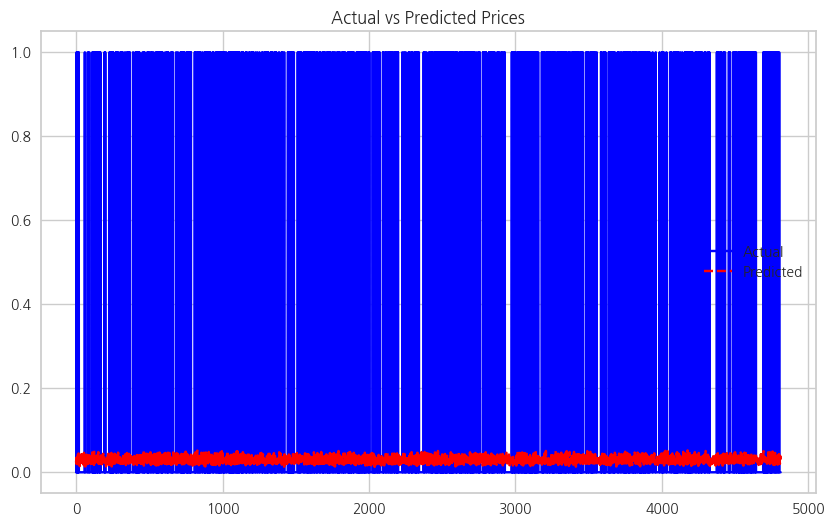

In [94]:
model.eval()  # 평가 모드

y_pred_list = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred = model(X_batch)
        y_pred_list.append(y_pred.numpy())

y_pred_list = np.vstack(y_pred_list)

# 성능 평가
mae = mean_absolute_error(y_test_tensor.numpy(), y_pred_list)
rmse = np.sqrt(mean_squared_error(y_test_tensor.numpy(), y_pred_list))
r2 = r2_score(y_test_tensor.numpy(), y_pred_list)

print(f"MAE (평균 절대 오차): {mae:.4f}")
print(f"RMSE (평균 제곱근 오차): {rmse:.4f}")
print(f"R² Score (결정계수): {r2:.4f}")

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor.numpy(), label='Actual', color='blue')
plt.plot(y_pred_list, label='Predicted', linestyle='dashed', color='red')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

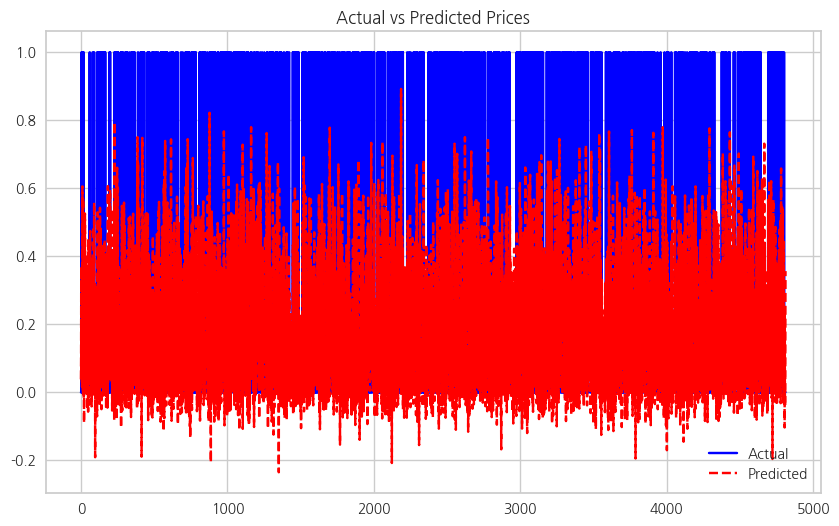

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor.numpy(), label='Actual', color='blue')
plt.plot(y_pred_list, label='Predicted', linestyle='dashed', color='red')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()